### 1. Importing packages

In [ ]:
import datetime
import pandas_datareader as pdr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

import yfinance as yf

import random

import torch
import torch.nn as nn
from torch.autograd import Variable

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from scipy.optimize import minimize

### 2. Loading dataset

In [ ]:
# top 30 U.S. companies by market capitalization
# except ABBV, FB, TSLA: listed after 2009-12-31
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'BRK-A', 'NVDA', 'V', 'JPM', 'UNH',
           'JNJ', 'BAC', 'WMT', 'PG', 'HD', 'MA', 'XOM', 'PFE', 'DIS', 'CVX',
           'KO', 'AVGO', 'PEP', 'CSCO', 'WFC', 'COST', 'LLY', 'ADBE']

In [ ]:
start_time = datetime.datetime(2009, 12, 31) # 2009-12-31
end_time = datetime.datetime(2021, 12, 31) # 2021-12-31

In [ ]:
# where to split training and validation datasets
all_split = 2517 # start 31/12/2009, val 02/01/2020, end 31/12/2021
# abbv_split = 1762 # start 02/01/2013
# fb_split = 1917 # start 18/05/2012
# tsla_split = 2394 # start 29/06/2010

In [ ]:
# getting datetimeindex
df = yf.download(tickers, start=start_time, end=end_time)
df.index = pd.to_datetime(df.index)

[*********************100%%**********************]  27 of 27 completed


In [ ]:
# dataframe for Adj Close price
act_adj_close_df = pd.DataFrame(index=df.index, columns=tickers)
for ticker in tickers:
    stock_price_df = yf.download(ticker, start=start_time, end=end_time)
    stock_price_df.index = pd.to_datetime(stock_price_df.index)
    act_adj_close_df[ticker] = stock_price_df['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [ ]:
act_adj_close_df.head()

,AAPL,MSFT,GOOG,AMZN,BRK-A,NVDA,V,JPM,UNH,JNJ,...,DIS,CVX,KO,AVGO,PEP,CSCO,WFC,COST,LLY,ADBE
Date,,,,,,,,,,,,,,,,,,,,,
2009-12-31,6.371568,23.075762,15.441621,6.7260,99200.0,4.283800,19.745789,28.818184,24.648182,42.472599,...,27.999454,43.810326,18.338371,13.119760,40.144836,16.367529,18.545887,42.394886,23.702984,36.779999
2010-01-04,6.470740,23.431587,15.610239,6.6950,99600.0,4.240229,19.899305,29.669838,25.497286,42.650620,...,27.843178,44.988239,18.351231,13.528632,40.435352,16.880302,18.772655,42.566853,23.775993,37.090000
2010-01-05,6.481929,23.439152,15.541497,6.7345,99710.0,4.302147,19.671293,30.244541,25.456850,42.156067,...,27.773718,45.306908,18.129232,13.629058,40.923962,16.805090,19.288004,42.437874,23.357821,37.700001
2010-01-06,6.378826,23.295321,15.149715,6.6125,99850.0,4.329668,19.407146,30.410728,25.707544,42.498962,...,27.626129,45.312607,18.122807,13.736656,40.514591,16.695700,19.315485,42.989571,23.530399,37.619999
2010-01-07,6.367031,23.053051,14.797037,6.5000,100000.0,4.244816,19.587753,31.013124,26.694117,42.195629,...,27.634815,45.141884,18.077765,13.650580,40.257072,16.770910,20.016369,42.781796,23.410929,36.889999


In [ ]:
# plotting parameters
plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams['axes.grid'] = True
plt.rcParams.update({'font.size': 12})

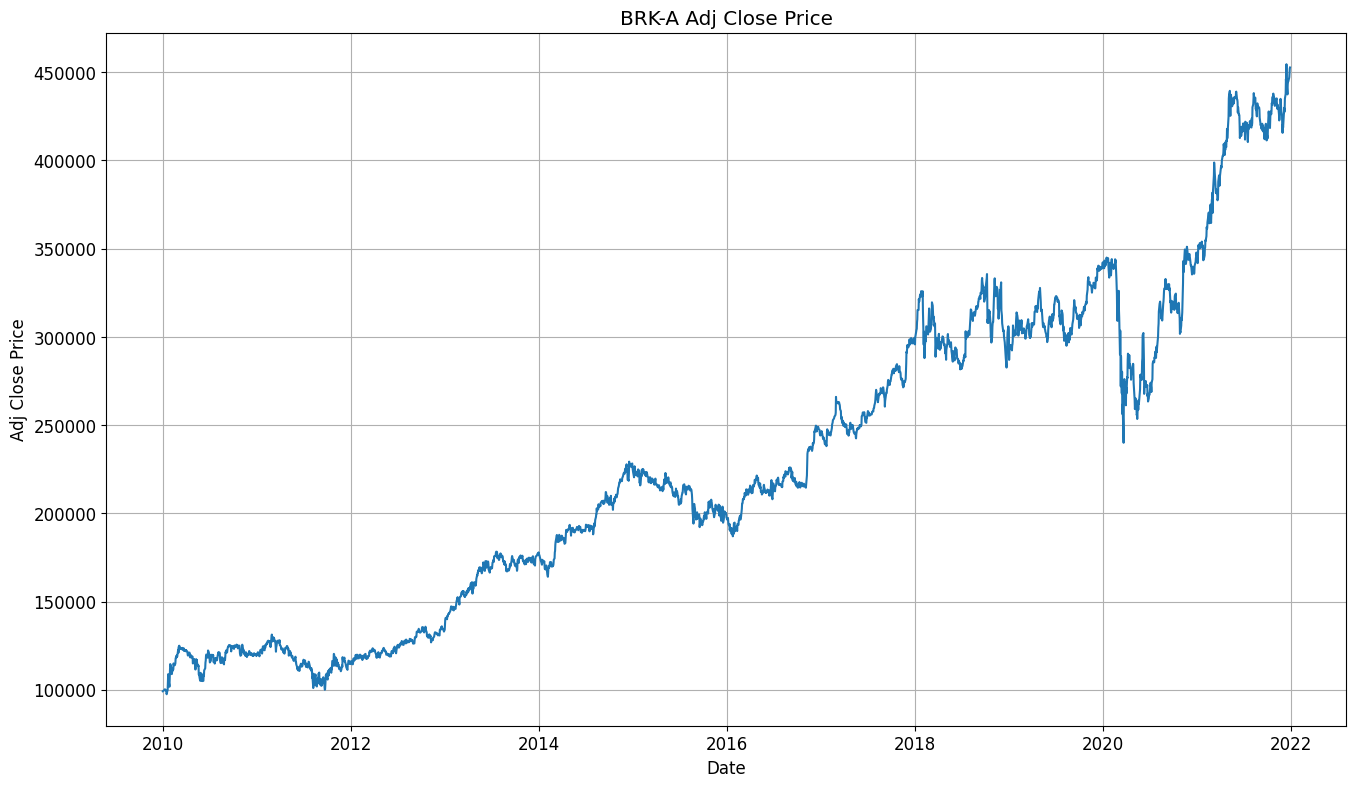

In [ ]:
# plotting Adj Close price distribution of random ticker
rand_ticker = random.choice(tickers)
plt.plot(act_adj_close_df[rand_ticker].index, act_adj_close_df[rand_ticker])
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.title(f'{rand_ticker} Adj Close Price')
plt.show()

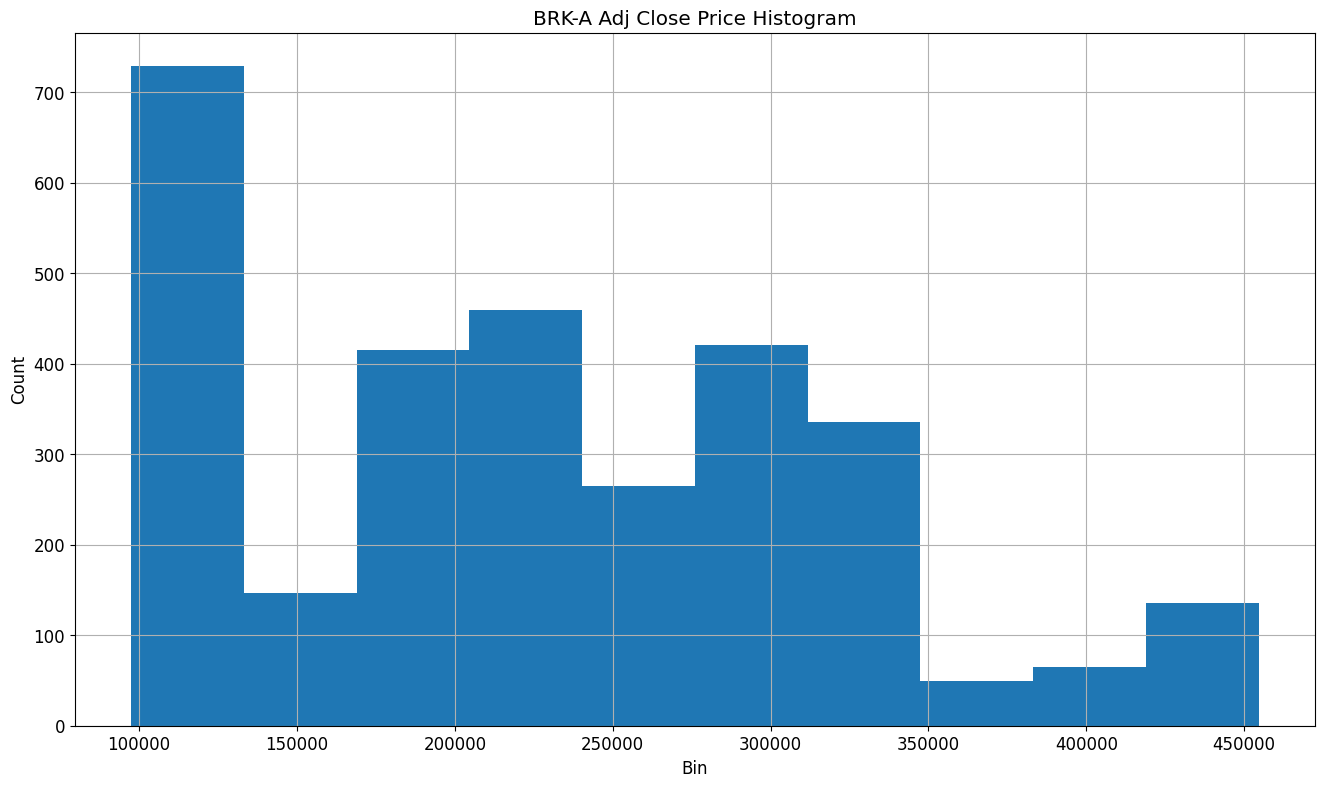

In [ ]:
# histogram
plt.hist(act_adj_close_df[rand_ticker])
plt.xlabel('Bin')
plt.ylabel('Count')
plt.title(f'{rand_ticker} Adj Close Price Histogram')
plt.show()

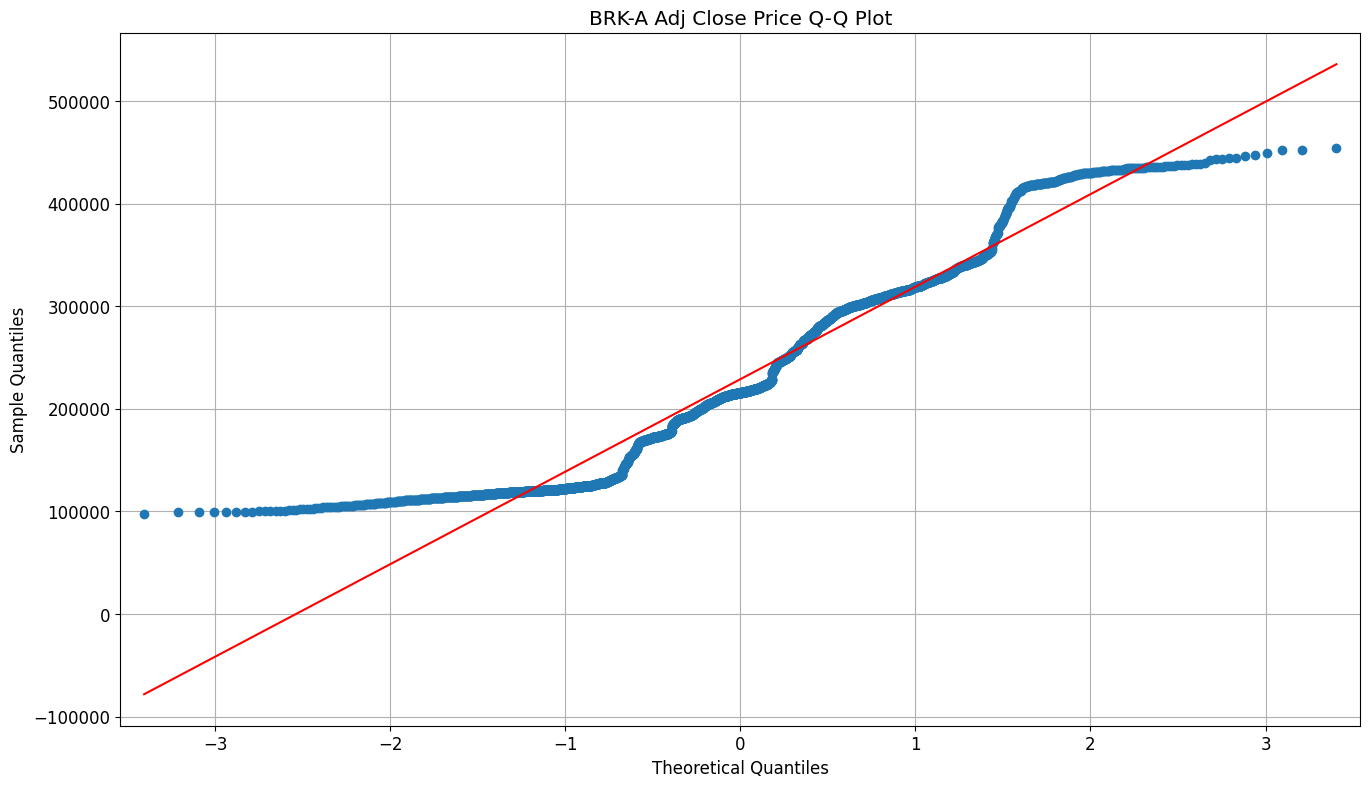

In [ ]:
# q-q plot
qqplot(act_adj_close_df[rand_ticker], line='s')
plt.title(f'{rand_ticker} Adj Close Price Q-Q Plot')
plt.show()

In [ ]:
act_adj_close_df.to_csv('act-adj-close-df.csv')

### 3. Building LSTM model

In [ ]:
# selecting gpu
device = torch.device('cpu')

In [ ]:
class LSTM_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM_model, self).__init__()
        self.input_size = input_size # number of features
        self.hidden_size = hidden_size # number of features in hidden state
        self.num_layers = num_layers # number of stacked LSTM layers
        self.num_classes = num_classes # number of output classes

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True) # LSTM layer
        self.fc = nn.Linear(hidden_size, num_classes) # fully connected last layer

    def forward(self, x):
        h0 = Variable(torch.zeros(self.num_layers, x.size(0),
                                  self.hidden_size)).to(device) # hidden state
        c0 = Variable(torch.zeros(self.num_layers, x.size(0),
                                  self.hidden_size)).to(device) # internal state
        # propagating input through LSTM
        out, _ = self.lstm(x, (h0, c0)) # out: tensor of shape (seq_length, batch_size, hidden_size)
        # decoding hidden state of last time step
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
# function for building model
def build_model(input_size=1, hidden_size=1, num_layers=1, num_classes=1, learning_rate=0.001):
    # learning rate controls how much to change model in response to estm error
    # each time model weights are updated

    model = LSTM_model(input_size, hidden_size, num_layers, num_classes).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # adam optimizer
    # algorithms/methods to change attributes of neural network such as weights and learning rate to reduce losses

    loss_function = torch.nn.MSELoss() # mean-squared error of regression
    # loss function measures how bad model performs: high loss -> low accuracy

    # loading model state
    # model = LSTM_model(*args, **kwargs)
    # model.load_state_dict(torch.load(PATH))
    # model.eval()

    return model, optimizer, loss_function

### 4. Model fitting and evaluation

In [ ]:
# scaler for normalizing dataset
scaler = MinMaxScaler()

In [ ]:
# function for creating X and y
def create_xy(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:i + time_step])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

In [ ]:
time_step = 100

In [ ]:
# dataframes for model loss, predicted Adj Close price and model performance
model_loss_df = pd.DataFrame(index=[epoch for epoch in range(0, 11000, 1000)], columns=tickers)
pred_adj_close_df = pd.DataFrame(index=df.index[time_step + 1:], columns=tickers)
model_perf_df = pd.DataFrame(index=['MAE', 'MSE', 'RMSE', 'MAPE', 'MPE'], columns=tickers)

In [ ]:
# functions for model performance evaluation
def MAE(y_true, y_hat):
    return np.mean(np.abs(y_true - y_hat))

def MSE(y_true, y_hat):
    return np.mean(np.square(y_true - y_hat))

def RMSE(y_true, y_hat):
    return np.sqrt(MSE(y_true, y_hat))

def MAPE(y_true, y_hat):
    return np.mean(np.abs((y_true - y_hat) / y_true)) * 100

def MPE(y_true, y_hat):
    return np.mean((y_true - y_hat) / y_true) * 100

In [ ]:
# function for fitting model
def fit_model(ticker, X_train, y_train):
    model, optimizer, loss_function = build_model()
    num_epochs = 10000

    loss_list = []

    for epoch in range(num_epochs + 1):
        outputs = model.forward(X_train.to(device)) # forward pass
        optimizer.zero_grad() # calculating gradient, manually setting to 0
        loss = loss_function(outputs, y_train.to(device)) # obtaining loss
        loss.backward() # calculating loss of loss function
        optimizer.step() # improving from loss, i.e. backprop

        if epoch % 1000 == 0:
            loss_list.append(loss.item())

    model_loss_df[ticker] = loss_list

    # saving model state
    torch.save(model.state_dict(), f'{ticker}-model-state.pth')

    return model

In [ ]:
# fitting models and predicting responses
for ticker in tickers:
    # normalizing dataset
    norm_act_adj_close = scaler.fit_transform(np.array(act_adj_close_df[ticker]).reshape(-1, 1))

    # if ticker == 'ABBV':
    #     train_set, val_set = norm_act_adj_close[:abbv_split], norm_act_adj_close[abbv_split:]
    # elif ticker == 'FB':
    #     train_set, val_set = norm_act_adj_close[:fb_split], norm_act_adj_close[fb_split:]
    # elif ticker == 'TSLA':
    #     train_set, val_set = norm_act_adj_close[:tsla_split], norm_act_adj_close[tsla_split:]
    # else:
    train_set, val_set = norm_act_adj_close[:all_split], norm_act_adj_close[all_split:]

    X_train, y_train = create_xy(train_set, time_step)
    X_val, y_val = create_xy(norm_act_adj_close, time_step)

    # converting datasets to tensors
    X_train_tensors = Variable(torch.Tensor(X_train))
    y_train_tensors = Variable(torch.Tensor(y_train))

    X_val_tensors = Variable(torch.Tensor(X_val))
    y_true = scaler.inverse_transform(y_val) # inverse transformation

    # fitting model
    print('----------')
    print(f'{ticker} fitting...')
    print(f'{len(tickers) - (tickers.index(ticker) + 1)} left')
    model = fit_model(ticker=ticker, X_train=X_train_tensors, y_train=y_train_tensors)

    # predicting response
    y_hat = model(X_val_tensors.to(device)) # forward pass
    y_hat = y_hat.data.detach().cpu().numpy() # numpy conversion
    y_hat = scaler.inverse_transform(y_hat) # inverse transformation
    print('Done!')

    pred_adj_close_df[ticker] = y_hat

    model_perf_df[ticker] = [MAE(y_true, y_hat), MSE(y_true, y_hat), RMSE(y_true, y_hat),
                             MAPE(y_true, y_hat), MPE(y_true, y_hat)]

----------
AAPL fitting...
26 left
Done!
----------
MSFT fitting...
25 left


### 5. Results

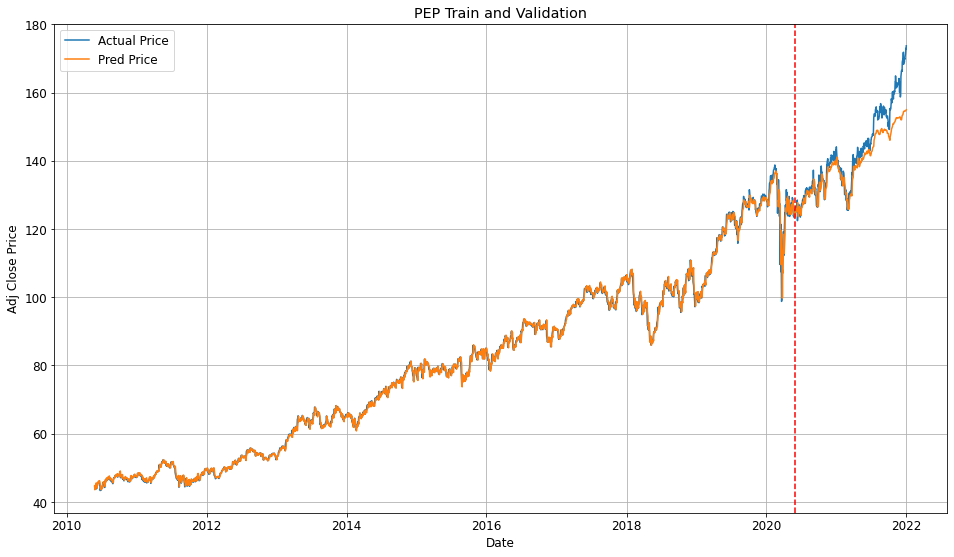

In [ ]:
# plotting actual and predicted Adj Close price of random ticker
rand_ticker = random.choice(tickers)
plt.plot(pred_adj_close_df.index, act_adj_close_df[rand_ticker][time_step + 1:], label='Actual Price')
plt.plot(pred_adj_close_df.index, pred_adj_close_df[rand_ticker], label='Pred Price')
plt.axvline(x=pred_adj_close_df.index[all_split], c='r', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.title(f'{rand_ticker} Train and Validation')
plt.legend()
plt.show()

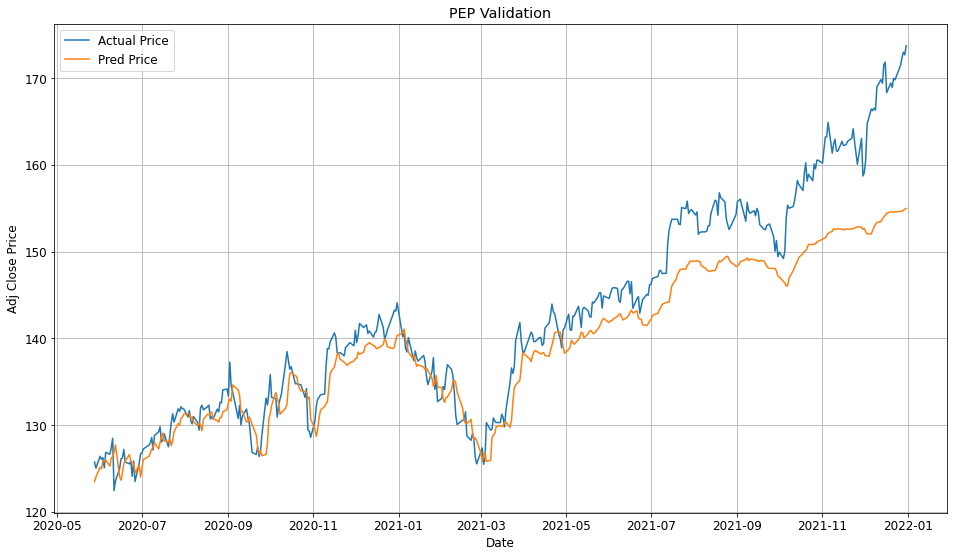

In [ ]:
val_act = act_adj_close_df[rand_ticker][time_step + 1 + all_split:]
val_pred = pred_adj_close_df[rand_ticker][all_split:]

plt.plot(pred_adj_close_df.index[all_split:], val_act, label='Actual Price')
plt.plot(pred_adj_close_df.index[all_split:], val_pred, label='Pred Price')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.title(f'{rand_ticker} Validation')
plt.legend()
plt.show()

In [ ]:
print(f'Val RMSE: {mean_squared_error(val_act, val_pred, squared=True)}')

Val RMSE: 29.846827483599103


In [ ]:
model_loss_df.tail()

,AAPL,MSFT,GOOG,AMZN,BRK-A,NVDA,V,JPM,UNH,JNJ,BAC,WMT,PG,HD,MA,XOM,PFE,DIS,CVX,KO,AVGO,PEP,CSCO,WFC,COST,LLY,ADBE
6000,0.000021,0.000012,0.000076,0.000046,0.000061,0.000027,0.000244,0.000038,0.000040,0.000137,0.000247,0.000062,0.000167,0.000028,0.000026,0.000274,0.000274,0.000068,0.000324,0.000287,0.000019,0.000043,0.000073,0.000428,0.000067,0.000039,0.000022
7000,0.000017,0.000012,0.000065,0.000037,0.000054,0.000020,0.000132,0.000035,0.000036,0.000099,0.000152,0.000054,0.000127,0.000026,0.000025,0.000251,0.000119,0.000056,0.000268,0.000180,0.000018,0.000037,0.000065,0.000373,0.000050,0.000028,0.000020
8000,0.000014,0.000011,0.000055,0.000030,0.000049,0.000014,0.000071,0.000033,0.000032,0.000078,0.000102,0.000049,0.000099,0.000022,0.000024,0.000238,0.000083,0.000047,0.000230,0.000115,0.000018,0.000034,0.000061,0.000318,0.000038,0.000023,0.000018
9000,0.000012,0.000010,0.000045,0.000026,0.000045,0.000010,0.000043,0.000032,0.000028,0.000065,0.000075,0.000047,0.000079,0.000020,0.000023,0.000233,0.000076,0.000042,0.000206,0.000082,0.000018,0.000032,0.000059,0.000270,0.000029,0.000021,0.000016
10000,0.000011,0.000010,0.000037,0.000022,0.000043,0.000007,0.000031,0.000032,0.000024,0.000056,0.000060,0.000046,0.000065,0.000017,0.000022,0.000232,0.000068,0.000039,0.000194,0.000068,0.000018,0.000031,0.000058,0.000232,0.000023,0.000021,0.000015


In [ ]:
pred_adj_close_df.head()

,AAPL,MSFT,GOOG,AMZN,BRK-A,NVDA,V,JPM,UNH,JNJ,BAC,WMT,PG,HD,MA,XOM,PFE,DIS,CVX,KO,AVGO,PEP,CSCO,WFC,COST,LLY,ADBE
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-05-27,7.606143,20.900383,253.116501,132.854019,107073.312500,2.808116,17.618608,28.802797,26.031683,43.080841,13.239719,38.715866,44.200977,26.791430,20.040274,38.138309,10.023575,28.653368,46.062035,18.433710,15.433213,44.764534,16.955162,21.277786,45.162640,23.602180,32.003780
2010-05-28,7.588778,20.385433,252.239944,131.698471,106410.195312,2.822936,17.603401,28.676672,25.982077,42.738377,13.215293,38.466721,44.025864,26.923393,19.850674,37.900032,9.993588,29.213737,45.506718,18.283274,15.826858,43.579453,16.684088,20.921850,44.956905,23.384100,31.586168
2010-06-01,7.723640,20.465137,253.749878,134.488449,109077.632812,2.914298,17.621416,29.894434,26.114611,42.586391,13.630380,38.834190,43.906853,27.213823,19.941143,39.279255,10.023681,30.246065,46.567730,18.423492,16.644514,44.904934,17.142462,21.241093,45.381870,23.443220,32.056488
2010-06-02,7.837989,20.432909,253.819458,133.739166,107585.757812,2.921126,17.505152,29.237463,26.136557,42.225655,13.497182,38.826088,43.849514,26.940298,19.642471,38.458588,10.003678,29.593744,46.611107,18.503843,16.468796,44.768562,16.886578,21.119785,45.532581,23.432035,32.198395
2010-06-03,7.953527,20.448292,253.487335,131.774704,106610.773438,2.863174,17.351246,28.487076,26.112743,42.300449,13.280352,39.037243,43.815521,26.827993,19.432926,37.845585,9.948062,29.476465,45.953831,18.514114,16.283592,44.694759,16.740652,20.913553,45.591347,23.356730,32.295792


In [ ]:
model_perf_df

,AAPL,MSFT,GOOG,AMZN,BRK-A,NVDA,V,JPM,UNH,JNJ,BAC,WMT,PG,HD,MA,XOM,PFE,DIS,CVX,KO,AVGO,PEP,CSCO,WFC,COST,LLY,ADBE
MAE,3.740152,4.728155,84.021242,74.501652,2.495489e+03,7.550619,2.691106,1.016674,6.454784,1.528268,0.586420,0.853321,1.520544,4.377627,2.127169,0.592254,0.562673,1.225729,0.900544,0.331889,6.114338,1.025589,0.323622,0.516946,7.794784,5.368077,7.035030
MSE,108.050382,172.719700,58875.475616,32774.897643,1.728923e+07,627.344244,32.218668,3.198116,272.937505,8.210513,1.740862,2.153378,7.658395,115.962558,16.912983,0.657876,1.727090,4.710295,1.762553,0.272092,252.364644,4.722364,0.291901,0.538614,475.974192,247.930782,331.975126
RMSE,10.394729,13.142287,242.642691,181.038387,4.158032e+03,25.046841,5.676149,1.788328,16.520820,2.865399,1.319417,1.467439,2.767381,10.768591,4.112540,0.811096,1.314188,2.170321,1.327612,0.521624,15.885989,2.173100,0.540279,0.733903,21.816833,15.745818,18.220185
MAPE,3.750831,2.693333,4.717559,3.483212,9.718272e-01,5.986184,2.191693,1.340974,2.635081,1.292752,2.507368,0.946682,1.612581,2.429800,1.364916,1.109538,1.967600,1.228161,1.126244,0.891798,2.508775,0.967078,1.133839,1.512398,2.728389,3.244396,2.209159
MPE,2.428678,1.440416,2.776650,1.739603,1.755912e-01,4.564700,0.583405,0.139092,1.077868,0.536867,0.543002,0.250529,0.561417,0.754571,0.106699,-0.147118,0.386847,0.172790,-0.017726,0.069579,0.643032,0.294847,0.011066,-0.030976,1.365565,2.065143,0.833260


In [ ]:
model_loss_df.to_csv('model-loss-df.csv')
pred_adj_close_df.to_csv('pred-adj-close-df.csv')
model_perf_df.to_csv('model-perf-df.csv')

In [ ]:
# act_adj_close_df = pd.read_csv('act-adj-close-df.csv', index_col=0)
# act_adj_close_df.index = pd.to_datetime(act_adj_close_df.index)

# model_loss_df = pd.read_csv('model-loss-df.csv', index_col=0)

# pred_adj_close_df = pd.read_csv('pred-adj-close-df.csv', index_col=0)
# pred_adj_close_df.index = pd.to_datetime(pred_adj_close_df.index)

# model_perf_df = pd.read_csv('model-perf-df.csv', index_col=0)

### 6. Building portfolios

In [ ]:
# daily returns of actual Adj Close price (validation phase)
act_adj_close_val_df = act_adj_close_df.iloc[time_step + 1 + all_split:, :]
act_daily_ret_df = act_adj_close_val_df.pct_change()
act_daily_ret_df = act_daily_ret_df.iloc[1:, :]
act_daily_ret_df.head()

,AAPL,MSFT,GOOG,AMZN,BRK-A,NVDA,V,JPM,UNH,JNJ,BAC,WMT,PG,HD,MA,XOM,PFE,DIS,CVX,KO,AVGO,PEP,CSCO,WFC,COST,LLY,ADBE
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-05-29,-0.000974,0.010199,0.008604,0.017188,0.005793,0.045776,0.005045,-0.025536,0.002895,0.012111,-0.029767,0.002991,-0.001206,0.013625,-0.004664,0.009547,0.000262,0.004711,0.009134,-0.008707,0.028714,-0.005594,0.048684,-0.027553,-0.003521,0.015267,0.017824
2020-06-01,0.012298,-0.002292,0.002029,0.011739,-0.010910,-0.007802,-0.004558,0.013257,0.003543,-0.010488,0.020315,-0.000806,0.011474,-0.004789,0.001695,0.017814,-0.071485,0.012532,0.011887,0.006641,-0.004395,0.010946,-0.031786,0.023423,-0.000584,-0.003269,0.007967
2020-06-02,0.004629,0.011377,0.005168,0.000554,0.010740,0.002158,0.010342,0.003347,0.001242,0.007202,0.009346,-0.000161,0.006908,0.021918,0.007266,0.022256,0.019740,-0.000168,0.020476,-0.001915,0.027829,-0.002707,0.012743,0.011443,-0.003892,0.009249,0.001950
2020-06-03,0.005505,0.002434,-0.001973,0.002423,0.027032,-0.006317,0.002597,0.053978,-0.003134,0.002698,0.046296,-0.003792,0.003981,-0.000836,0.011463,0.040795,0.000000,0.028884,0.026296,0.021322,0.038482,0.001433,0.001066,0.052190,-0.001465,-0.008644,-0.001332
2020-06-04,-0.008612,-0.013163,-0.016848,-0.007182,0.006250,0.000114,-0.016407,0.020811,-0.023809,-0.012916,0.037582,-0.011015,-0.020923,-0.008167,-0.018563,-0.002843,-0.004148,0.012359,-0.009261,0.000417,-0.002067,-0.009310,-0.001704,0.048214,0.013403,-0.011932,-0.010566


In [ ]:
# daily returns of predicted Adj Close price (validation phase)
pred_adj_close_val_df = pred_adj_close_df.iloc[all_split:, :]
pred_daily_ret_df = pred_adj_close_val_df.pct_change()
pred_daily_ret_df = pred_daily_ret_df.iloc[1:, :]
pred_daily_ret_df.head()

,AAPL,MSFT,GOOG,AMZN,BRK-A,NVDA,V,JPM,UNH,JNJ,BAC,WMT,PG,HD,MA,XOM,PFE,DIS,CVX,KO,AVGO,PEP,CSCO,WFC,COST,LLY,ADBE
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-05-29,0.002415,-0.001748,0.002319,-0.003874,0.027175,-0.013057,0.001574,0.057023,0.018178,0.000099,0.059965,-0.010258,0.004703,0.014144,-0.004081,0.003897,-0.000964,0.007092,0.009060,0.014054,0.017841,0.004461,0.024634,0.052768,0.002415,-0.008515,-0.005857
2020-06-01,0.001647,-0.001902,0.001565,-0.003405,0.003958,-0.007727,0.003729,-0.014528,0.008114,0.006850,-0.010368,0.008783,0.009578,-0.003698,0.005905,-0.028018,0.006849,-0.033195,-0.028543,0.009367,-0.006874,0.008882,-0.007920,0.008371,0.005109,0.004636,0.003811
2020-06-02,0.000903,0.003077,0.003317,0.005514,0.005151,0.015331,0.003680,-0.026009,0.004762,0.008623,-0.021935,0.002935,0.004839,0.009131,-0.002152,0.014533,0.003491,-0.000900,0.005148,-0.002953,0.018828,-0.001175,0.047024,-0.010168,0.001788,0.003811,0.010851
2020-06-03,0.004679,0.000516,0.002438,0.007373,-0.006207,0.002733,0.000145,0.013562,0.003664,-0.001155,0.006386,-0.000675,0.007190,-0.001846,0.000976,0.016446,-0.023780,0.011192,0.011471,0.003401,0.001350,0.006816,-0.030201,0.008185,0.001019,0.000155,0.008764
2020-06-04,0.003721,0.004886,0.002900,0.003623,0.005699,0.002471,0.004052,0.003455,0.002164,0.002751,0.007795,-0.000164,0.006599,0.014616,0.005220,0.021861,-0.005446,0.001404,0.019669,-0.000158,0.020197,0.000297,0.012593,0.009612,-0.000554,0.003156,0.004715


In [ ]:
# dataframe for daily portfolio returns
act_daily_port_ret_df = act_daily_ret_df.copy()
act_daily_port_ret_df.drop(columns=tickers, inplace=True)

In [ ]:
# risk free return
risk_free_ret = 0.015

In [ ]:
# function for adding different portfolios
def add_portfolio(portfolio, weights):
    act_daily_port_ret_df[f'{portfolio} Return'] = act_daily_ret_df.dot(weights)
    if portfolio == 'Pred':
        # upper bound of security transaction tax: 0.0003
        act_daily_port_ret_df[f'{portfolio} Return'] = act_daily_port_ret_df[f'{portfolio} Return'] - 0.0003
    act_daily_port_ret_df[f'{portfolio} Cum Prod Return'] = (1 + act_daily_port_ret_df[f'{portfolio} Return']).cumprod()

    exp_ret = act_daily_port_ret_df[f'{portfolio} Return'].mean()
    std = act_daily_port_ret_df[f'{portfolio} Return'].std()
    sharpe_ratio = (exp_ret - risk_free_ret) / std

    print(portfolio)
    print('Weights:')
    print(weights)
    print(f'Expected Return: {exp_ret:.6f}')
    print(f'Standard Dev   : {std:.6f}')
    print(f'Sharpe Ratio   : {sharpe_ratio:.6f}')

#### Equally weighted portfolio

In [ ]:
n_assets = len(tickers)
eq_weights = np.ones(n_assets) / n_assets

In [ ]:
add_portfolio('Eq', eq_weights)

Eq
Weights:
[0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
 0.03703704 0.03703704 0.03703704]
Expected Return: 0.001363
Standard Dev   : 0.009507
Sharpe Ratio   : -1.434444


In [ ]:
sum(eq_weights)

0.9999999999999993

#### Market capitalization weighted portfolio

In [ ]:
cap_data = pdr.get_quote_yahoo(tickers)['marketCap']
cap_df = pd.DataFrame(cap_data)
cap_df['Weight'] = cap_df / cap_df.sum()
cap_weights = np.array(cap_df['Weight'])

In [ ]:
add_portfolio('Cap', cap_weights)

Cap
Weights:
[0.16697249 0.13884953 0.11027403 0.0968426  0.04322891 0.03720673
 0.02958506 0.0268349  0.02696805 0.02614107 0.02212054 0.02346136
 0.02287096 0.02056477 0.02287991 0.02020129 0.01621853 0.01710089
 0.01634311 0.01649338 0.01493648 0.01424614 0.01429408 0.01287715
 0.01409494 0.01461916 0.01377393]
Expected Return: 0.001558
Standard Dev   : 0.011106
Sharpe Ratio   : -1.210383


In [ ]:
sum(cap_weights)

0.9999999999999999

#### LSTM predictions portfolio

In [ ]:
# function for getting inverse of expected return using predicted Adj Close price
# used to get optimum weights that maximize this expected return
def exp_ret_inv(weights):
    pred_daily_port_ret = pred_daily_ret_df.dot(weights)
    exp_ret = pred_daily_port_ret.mean()
    return 1 / exp_ret

In [ ]:
# expected return maximization using predicted Adj Close price
weights0 = eq_weights # initial weights
# bounds: weight should be between 0.0 and 1.0
bnds = tuple((0.0, 1.0) for i in range(n_assets))
# constraints: weights should add up to 1.0
cons = ({'type': 'eq', 'fun': lambda W: np.sum(W) - 1.0})

res = minimize(exp_ret_inv, weights0, method='SLSQP', bounds=bnds, constraints=cons)
pred_weights = res.x

In [ ]:
add_portfolio('Pred', pred_weights)

Pred
Weights:
[2.99830728e-13 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 9.93840540e-14 2.73451002e-14 2.93621267e-14
 4.22093268e-14 1.71972384e-13 0.00000000e+00 1.33712495e-13
 0.00000000e+00 0.00000000e+00 2.00840102e-13 4.64139603e-14
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.99165132e-13
 1.00000000e+00 0.00000000e+00 2.60437670e-14 1.68158091e-13
 2.33257176e-14 6.32196592e-14 2.11304091e-15]
Expected Return: 0.002126
Standard Dev   : 0.017988
Sharpe Ratio   : -0.715694


In [ ]:
sum(pred_weights)

1.0000000000015201

#### Plotting cummulative product returns

In [ ]:
act_daily_port_ret_df

,Eq Return,Eq Cum Prod Return,Cap Return,Cap Cum Prod Return,Pred Return,Pred Cum Prod Return
Date,,,,,,
2020-05-29,0.005587,1.005587,0.006629,1.006629,0.028414,1.028414
2020-06-01,0.000533,1.006123,0.002719,1.009367,-0.004695,1.023586
2020-06-02,0.008113,1.014285,0.007000,1.016432,0.027529,1.051764
2020-06-03,0.012644,1.027110,0.008207,1.024774,0.038182,1.091922
2020-06-04,-0.002603,1.024436,-0.006706,1.017902,-0.002367,1.089337
...,...,...,...,...,...,...
2021-12-27,0.011742,1.705772,0.012831,1.844787,0.013960,2.237403
2021-12-28,-0.000690,1.704595,-0.002015,1.841069,-0.008131,2.219212
2021-12-29,0.001018,1.706330,0.000190,1.841419,0.005096,2.230521


In [ ]:
adoi = pred_adj_close_df.index[all_split] - datetime.timedelta(days=1)
print(f'Assumed Date of Investment: {adoi.date()}')

Assumed Date of Investment: 2020-05-27


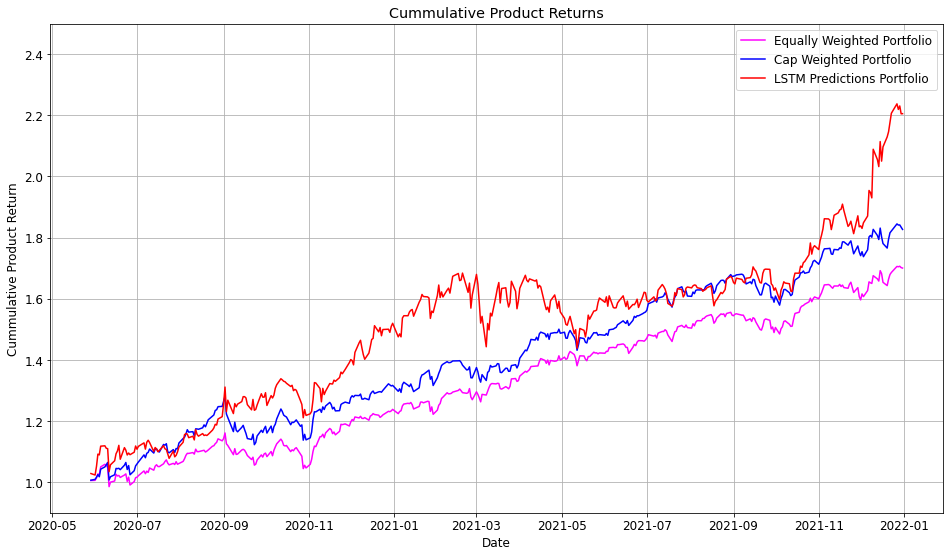

In [ ]:
plt.plot(act_daily_port_ret_df.index, act_daily_port_ret_df['Eq Cum Prod Return'],
         label='Equally Weighted Portfolio', color='fuchsia')
plt.plot(act_daily_port_ret_df.index, act_daily_port_ret_df['Cap Cum Prod Return'],
         label='Cap Weighted Portfolio', color='blue')
plt.plot(act_daily_port_ret_df.index, act_daily_port_ret_df['Pred Cum Prod Return'],
         label='LSTM Predictions Portfolio', color='red')
plt.xlabel('Date')
plt.ylabel('Cummulative Product Return')
plt.title('Cummulative Product Returns')
plt.ylim(0.9, 2.5)
plt.legend()
plt.show()